# Building a Time Series Dataset with Features

In [1]:
#First of all, define the ETF that will be analyzed:
#Our main asset is the XLP (Consumer staples ETF). Our secondary asset ins the XLY (Consumer Discretionary ETF)
asset = 'XLP'

In [2]:
from src.config import *
set_seeds()

#In case you need to import just these self-made modules above (e.g.: you modified it and need it to be reloaded)
#My own libraries
"""
import importlib
import src.Databases
importlib.reload(src.Databases)


import importlib
import src.increase_dataset
importlib.reload(src.increase_dataset)


import importlib
import src.FutureReturn_calc
importlib.reload(FutureReturn_calc)
from FutureReturn_calc import stopLossFutRet
"""

'\nimport importlib\nimport src.Databases\nimportlib.reload(src.Databases)\n\n\nimport importlib\nimport src.increase_dataset\nimportlib.reload(src.increase_dataset)\n\n\nimport importlib\nimport src.FutureReturn_calc\nimportlib.reload(FutureReturn_calc)\nfrom FutureReturn_calc import stopLossFutRet\n'

In [3]:
#===========Libraries versions=======================================
print(f'Pandas version', pd.__version__)
print(f'Numpy version', np.__version__)
print(f'Yahoo Finance', yf.__version__)
print(f'Pandas_ta', ta.__version__)

Pandas version 1.4.3
Numpy version 1.21.5
Yahoo Finance 0.1.74
Pandas_ta 0.3.14b0


In [4]:
#From my own library, what are the assets registered in the dictionary already
c= dataset()
print(f'\n============================================================ \
        \nDictionary of registered assets:\n\n{c.descript_dict}\n \
============================================================\n')


Dictionary of registered assets:

{'XLP': 'U.S. Consumer Staples Sector ETF'}



### Updating the Datasets with yfinance data and saving a new CSV in directory

In [5]:
#Updating the Staples ETF database with most recent data
'''
list_assets = c.list_of_assets()

for l in list_assets:
    c= dataset()
    c.importDatabase(l)
'''

'\nlist_assets = c.list_of_assets()\n\nfor l in list_assets:\n    c= dataset()\n    c.importDatabase(l)\n'

### Import the CSV file from folder

In [6]:
#IMPORTING THE DATASET
#df = pd.read_csv(f'datasets/{asset}_intraday.csv', index_col=0, parse_dates=True, delimiter=',')[['Open','High','Low','Close','Volume']]
df = pd.read_csv(f'datasets/{asset}_historical_max.csv', index_col=0, parse_dates=True, delimiter=',')[['Open','High','Low','Close','Volume']]
#Deleting unecessary columns -> You dont need this anymore since you are specifying above the columns you want
#df1 = df.drop(['Dividends', 'Stock Splits', 'ticker', 'Adj Close'], axis=1) #You dont need this since you are specifying above the columns you want

#Saving the figure as an image (for reports)
#dfi.export(df, 'figures_tables/XLPDataframe.png')
#df.style.background_gradient().export_png('figures_tables/XLPDataframe.png')
#df.tail(10).dfi.export(f'figures_tables/{asset}Dataframe.png', table_conversion='matplotlib')
#df.iloc[-50:-20,:]

In [7]:
#RESET INDEX
df.reset_index(drop=False, inplace=True)

#In case your previous index column has the name "index", and you want to change it properly
#df.rename(columns = {'index':f'date'}, inplace = True) #Rename the date's column otherwise it will have the same name
#of previous dataset's column

#df

In [8]:
df1 = df.copy(deep=True)
del df
gc.collect()

58

In [9]:
#Converting the data in datetime and float

#df1.reset_index(drop=False, inplace=True)

print(f'\nPrevious dtypes:\n{df1.dtypes}\n')
convert_dict = {'Date': 'datetime64[ns]',
                'Open': float,
                'High': float,
                'Low': float,
                'Close': float,
                'Volume': float}
 
df1 = df1.astype(convert_dict, errors='raise')
#df1['Date'] = pd.to_datetime(df1['Date']).dt.date

print(f'\nUpdated dtypes:\n{df1.dtypes}\n')


Previous dtypes:
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object


Updated dtypes:
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object



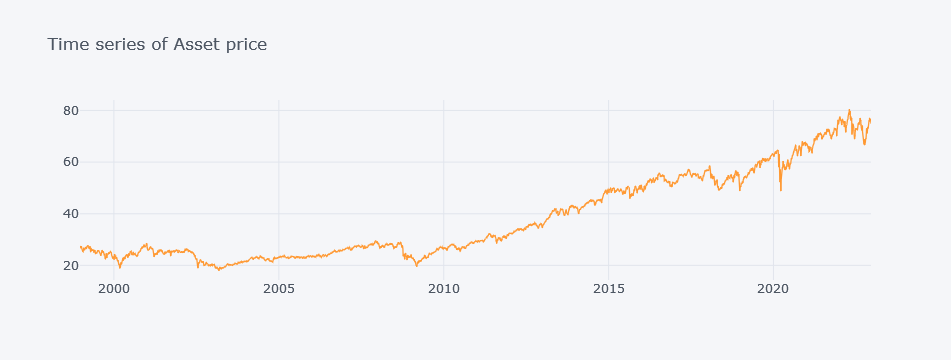

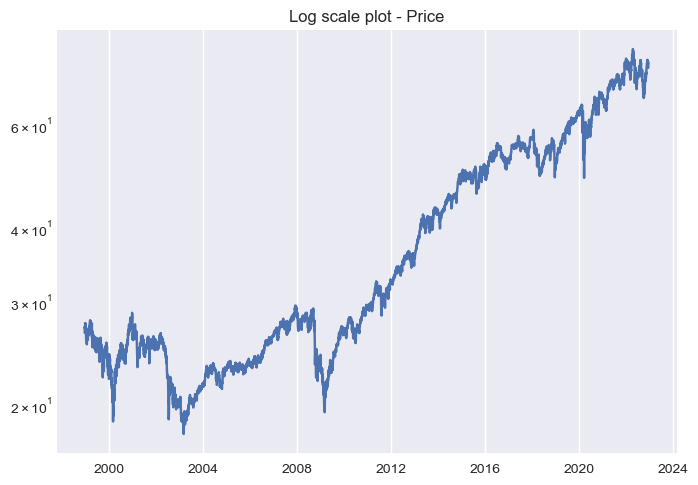

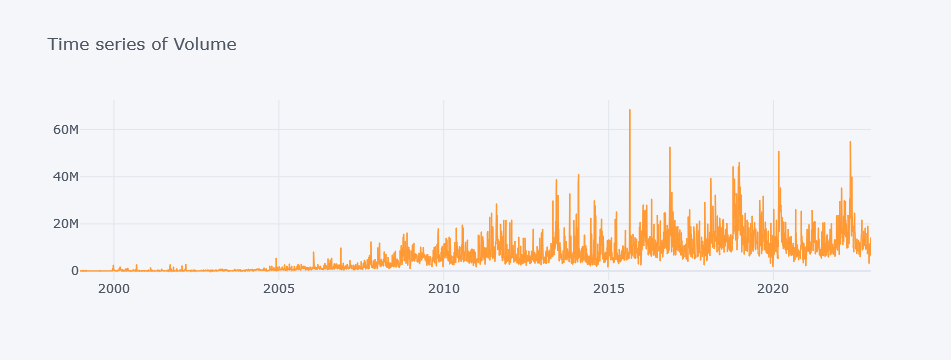

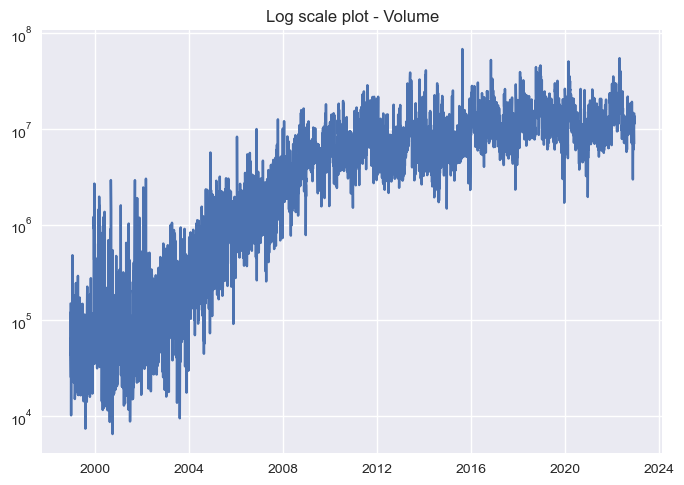

In [10]:
#Plotting graphs

df_plot = df1.copy(deep=True)
df_plot.reset_index(drop=False, inplace=True)
df_plot['Date'] = pd.to_datetime(df_plot['Date']).dt.date
df_plot.dtypes


try:
    df_plot = df_plot.set_index('Date')
except:
    pass

datalimitmin = pd.to_datetime('1996-12-31').date()
datalimitmax = pd.to_datetime('2024-12-31').date()
#=======Closing price=============================================================================================
# Closing price - Raw data
title = 'Asset price'
df_plot = df_plot[  (df_plot.index > datalimitmin) & (df_plot.index < datalimitmax) ]      #When the 'Date' is in the INDEX
#df_plot = df_plot[  (df_plot['Date'] > datalimitmin) & (df_plot['Date'] < datalimitmax) ] #When the 'Date' is in the COLUMNS
df_plot['Close'].iplot(kind='line', title=f'Time series of {title}')

#====================================================================================================
#Closing price - Log scale
data = df_plot['Close']
fig, ax = plt.subplots()
ax.set_title("Log scale plot - Price")
ax.plot(data)
ax.set_yscale('log')
plt.show()

#========VOLUME======================================================================================

# ASSET
title = 'Volume'
df_plot['Volume'].iplot(kind='line', title=f'Time series of {title}')

#====================================================================================================
#Log scale
data = df_plot['Volume']
fig, ax = plt.subplots()
ax.plot(data)
ax.set_title("Log scale plot - Volume")
ax.set_yscale('log')
plt.show()

# Building features - X variables - Indep Variables

### Techical Features - Pandas TA

In [11]:
#TECHNICAL ANALYSIS -> PANDAS_TA Features columns
#Using pandas-ta


df_taAll = df1.copy(deep=True)
df_taAll.set_index('Date',inplace=True)
df_taAll = df_taAll[['Open','High','Low','Close','Volume']]
df_taAll.ta.strategy('All')
#Drop unwanted columns: DPO_20, for example, had a strong significance in our model, but we discovered that it has Data Leakage
df_taAll.drop(['DPO_20', 'HILOl_13_21', 'HILOs_13_21', 'PSARl_0.02_0.2', 'PSARs_0.02_0.2', 'PSARaf_0.02_0.2', 'QQEl_14_5_4.236',
            'QQEs_14_5_4.236', 'SUPERTl_7_3.0', 'SUPERTs_7_3.0'], axis=1, inplace=True)

#Checking for missing data: if there aren't much, you can drop the NaN rows and it wont impact your dataset
#df_ta.isnull().sum()[190:250]

#Drop the NaN Columns
#We wont drop the NaN columns now, otherwise we are gonna lost the most recent data (which will be useful when implementint the trading strat)

#df_ta = df_ta.bfill(axis=1) #Dont think its good to use bfill, since we might be using future data (Data Leakage

df_taAll.tail(10)

del df1,df_plot
gc.collect()

131it [00:07, 17.61it/s]


10573

In [12]:
# Defining the features that will be used
list_feat = ['Close','EOM_14_100000000','PGO_14','SQZ_20_2.0_20_1.5','DMP_14','close_Z_30_1']
df_ta = pd.DataFrame(df_taAll, columns=list_feat)
print(f'Null Count for each feature: if there is too much, is better remove the Feature from the\
      dataset\n{df_ta.isnull().sum()}')

df1 = df_ta.copy(deep=True)
df1.dropna(inplace=True)
df1.reset_index(drop=False, inplace=True)

print(f'\nAfter df.dropna(), check if there\'s still any NaN\ndf1 Dataset isnull sum:\n{df1.isnull().sum()}')


Null Count for each feature: if there is too much, is better remove the Feature from the      dataset
Close                 0
EOM_14_100000000     14
PGO_14               14
SQZ_20_2.0_20_1.5    17
DMP_14               14
close_Z_30_1         29
dtype: int64

After df.dropna(), check if there's still any NaN
df1 Dataset isnull sum:
Date                 0
Close                0
EOM_14_100000000     0
PGO_14               0
SQZ_20_2.0_20_1.5    0
DMP_14               0
close_Z_30_1         0
dtype: int64


# About PANDAS_TA

In [13]:

dftest = pd.DataFrame()
dftest.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [14]:
#help(ta.eom)
#help(ta.pgo)
#SQZ: info in the folder
#DMP_14: description in the folder
#close_Z_30_1: description in the folder

In [15]:
help(ta.log_return)

Help on function log_return in module pandas_ta.performance.log_return:

log_return(close, length=None, cumulative=None, offset=None, **kwargs)
    Log Return
    
    Calculates the logarithmic return of a Series.
    See also: help(df.ta.log_return) for additional **kwargs a valid 'df'.
    
    Sources:
        https://stackoverflow.com/questions/31287552/logarithmic-returns-in-pandas-dataframe
    
    Calculation:
        Default Inputs:
            length=1, cumulative=False
        LOGRET = log( close.diff(periods=length) )
        CUMLOGRET = LOGRET.cumsum() if cumulative
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 20
        cumulative (bool): If True, returns the cumulative returns. Default: False
        offset (int): How many periods to offset the result. Default: 0
    
    Kwargs:
        fillna (value, optional): pd.DataFrame.fillna(value)
        fill_method (value, optional): Type of fill method
    
    Retu

### Saving the dataset as CSV file

In [16]:
df1.columns

Index(['Date', 'Close', 'EOM_14_100000000', 'PGO_14', 'SQZ_20_2.0_20_1.5',
       'DMP_14', 'close_Z_30_1'],
      dtype='object')

In [17]:
df1.to_pickle(f'datasets/{asset}_dataset_allFeatures.pkl')

In [18]:
# Removing unused datasets from memory
del df_ta, df_taAll
gc.collect()


29

### Building the Y LABEL - dependet variable 

In [19]:
df1 = pd.read_pickle(f'datasets/{asset}_dataset_allFeatures.pkl')
#df.tail(300)
df1.shape

(6008, 7)

In [20]:
df1.set_index('Date',inplace=True)

In [21]:
# Params
#------------------------------------------------------------------------------
#Return period span:
quantile_defined = 0.7
period = 5
stopLimit=-0.40 #Stop loss limit which makes the strategy sell the position before the due date period (defined above)
highLimit = 0.40 #Limit of positive return that makes the strategy liquidate the position before the window period
col = 'Close'
splitSize = 0.2 # %of the data for training and test. We will use it to calculate the quantile return
totalLenData = len(data)
train_size = int(totalLenData*(1-splitSize))


In [22]:
# Creating columns: log return and dependent variable Y (Classes)
# LOG_RETURN AND Y_BINARY_CLASS COLUMNS

#1) Base column - Daily Returns
returns = np.log(df1['Close']).diff(1) #numpy log function
returns_period = np.log(df1['Close']).diff(period) #numpy log function
df1['return_1d'] = returns
df1['return_period'] = returns_period

data =  df1.copy(deep=True)
#data = data.set_index('Date') #Just in case the column 'Date' is not set as index yet

#------------------------------------------------------------------------------------------------------
#Function to calculate FUTURE RETURN: this function permits to estipulate stoploss and maximum positive return before the established period ends 
stopLossFutRet(data, col, period, stopLimit, highLimit)
    
print(f"Fut return analysis describe:\n{data['Fut_return_period'].describe()}")

#If the posterior date return is bigger than the defined quantile or a value, 1, otherwise, 0
quantile_val = data['Fut_return_period'][:train_size].quantile(quantile_defined) #Should be calculated just on train data (data leak otherwise)
print(f"\nQuantile value({quantile_defined}) = ", quantile_val)

#data['predict'] = np.where(data['Fut_return_period']>quantile_val,1,0)
data['predict'] = np.where(data['Fut_return_period']>quantile_val,1,0)

df_recent = data.copy(deep=True) #We are going to save this df before we cut the most recent prices. They will be useful in the real trading 
df_recent = data[-period:] #This dataset will be used in the day to day trade. Prediction based on most recent prices.

#Drop the NaN Columns
data.dropna(inplace=True)

data = data[:-period] #last X days which don't have the future return yet - taking care of Xday ahead prediction
#------------------------------------------------------------------------

#how the classes of Y_variable are distributed (number of 1s and 0s, or 1s and -1s)
print('\n Dataset Shape')
print(data.shape)

print('\nY_variable value counts')
print(data['predict'].value_counts())

#Check for missing values
print("\nIs there missing values in columns")
print(data.isnull().sum())
print("\n")
pd.options.display.float_format = '{:.4f}'.format #SUPRESS THE SCIENTIFIC NOTATION

Fut return analysis describe:
count    6008.000000
mean        0.001086
std         0.019894
min        -0.158955
25%        -0.008620
50%         0.002014
75%         0.011842
max         0.143327
Name: Fut_return_period, dtype: float64

Quantile value(0.7) =  0.009384071664132243

 Dataset Shape
(5998, 11)

Y_variable value counts
0    4152
1    1846
Name: predict, dtype: int64

Is there missing values in columns
Close                0
EOM_14_100000000     0
PGO_14               0
SQZ_20_2.0_20_1.5    0
DMP_14               0
close_Z_30_1         0
return_1d            0
return_period        0
Fut_return_period    0
PosStop              0
predict              0
dtype: int64




In [23]:
#Drop the OHLCV columns, since we don't need them and they may mess up the results
data.drop(['Close'], axis=1, inplace=True)

In [24]:
#data.iloc[-40:,-5:] #Checking the last columns of the dataframe

### Distribution Plot

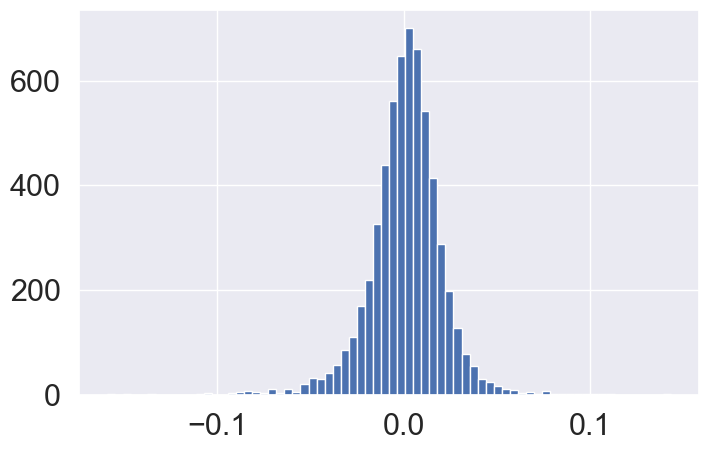

MEAN = 0.0010825737627999808
MED = 0.002026248187254165
Std: 0.019906344062350978
MIN = -0.15895535715603526
MAX = 0.14332710781237878


In [25]:
features = data['Fut_return_period']
sns.set(font_scale=2)
features.hist(bins=70, figsize=(8,5))
plt.show()

mean = data['Fut_return_period'].mean()
med = data['Fut_return_period'].median()
maxVal = data['Fut_return_period'].max()
minVal = data['Fut_return_period'].min()
stdDev = data['Fut_return_period'].std()


print(f'MEAN = {mean}')
print(f'MED = {med}')
print(f'Std: {stdDev}')
print(f'MIN = {minVal}')
print(f'MAX = {maxVal}')
    

# Normality test 

In [26]:
#Shapiro-Wilk Normality test
from scipy.stats import shapiro
stat, p = shapiro(features)
print('stat=%.3f, p=%.3f' % (stat,p))
if p > 0.05:
    print(f'probably Gaussian')
else:
    print('probably not Gaussian')

stat=0.944, p=0.000
probably not Gaussian


### Outliers: check if there are outliers and exclude them using .clip() method

In [27]:
#CHecking if there are outliers in each feature

#list_col = list(data.columns)
list_col = ['Fut_return_period']
'Fut_return_period'
for c in list_col:
    print(f'Outliers {c}')
    q25, q75 = data[c].quantile([0.25, 0.75]) #Quantiles
    iqr = q75 - q25 #Interquartile range
    print("q25: ", q25)
    print("q75: ", q75)
    print("Interquartile range: ", iqr)

    lowerB = q25 - iqr*1.5
    upperB = q75 + iqr*1.5  

    print("LowerBound: ", lowerB)
    print("UpperBound: ", upperB)

    #Outliers - checking if there is any outlier.
    column_temp = data[c]
    if (column_temp>upperB).sum() > 0:
      print(f'Yes, there are {(column_temp>upperB).sum()} UPPER outliers in {c}.')
    else: 
      print(f'No, there is no UPPER outlier in {c}')
    
    if (column_temp<lowerB).sum() > 0:
      print(f'Yes, there are {(column_temp<lowerB).sum()} LOWER outliers in {c}.')
    else: 
      print(f'No, there is no LOWER outlier in {c}')

    print("\n")

Outliers Fut_return_period
q25:  -0.008635261194049726
q75:  0.011844044943864096
Interquartile range:  0.020479306137913822
LowerBound:  -0.03935422040092046
UpperBound:  0.04256300415073483
Yes, there are 106 UPPER outliers in Fut_return_period.
Yes, there are 174 LOWER outliers in Fut_return_period.




In [28]:
#Clip the Fut_returns column to get rid of outliers: the clip function trim the values into a specified threshold

#data['Fut_return_period'] = data['Fut_return_period'].clip(lower=lowerB, upper=upperB)

In [29]:
data.columns

Index(['EOM_14_100000000', 'PGO_14', 'SQZ_20_2.0_20_1.5', 'DMP_14',
       'close_Z_30_1', 'return_1d', 'return_period', 'Fut_return_period',
       'PosStop', 'predict'],
      dtype='object')

### Saving the dataset with all features and Y

In [30]:
data.to_csv(f'datasets/{asset}_XandY_dataset_allFeatures.csv')
#Now that we have the whole dataset saved, we can drop the unwanted columns
data = data.drop('PosStop',axis=1)

In [31]:
#Saving this dataset, since we have the y variable now
data.to_csv(f"datasets/dataset_allXFeatures_yVariable.csv")
df_recent.to_csv(f"datasets/MOSTRECENTdataset_allXFeatures_yVariable.csv")

### Adjusting the imbalance of y label classes

In [32]:
#Dealing with imbalance in the y_label classes
data['predict'].value_counts()

0    4152
1    1846
Name: predict, dtype: int64

In [33]:
# class weight function
def cwts(dfs):
    c0, c1 = np.bincount(dfs['predict'])
    w0=(1/c0)*(len(dfs))/2 
    w1=(1/c1)*(len(dfs))/2 
    return {0: w0, 1: w1}

# check class weights
class_weight = cwts(data)
class_weight

{0: 0.7223025048169557, 1: 1.6245937161430117}

In [34]:
# Proof With the calculated weights, both classes gain equal weight
c0, c1 = np.bincount(data['predict'])
class_weight[0] * c0, class_weight[1] * c1

(2999.0, 2998.9999999999995)

In [35]:
# Checking the column's names to delete the unecessary
#list(data.columns)

### Defining X variables and y variable, Train and Test sets

# ==========================================================================================
# LSTM model using TensorFlow

In [36]:
"""
Tensorboard gives an error in Windows when we try to reuse it in opened Port from our pc, thus we have to manually delete
the folder located in temp. Below is an explanation of Stack Overflow:
So, the answer to your question is, “remove the .tensorboard-info directory located under tempfile.gettempdir()” 
(preferably when you don’t have any actively running TensorBoard instances).
"""
import tempfile
tempfile.gettempdir() #Check the path of your temp directory

'C:\\Users\\ricar\\AppData\\Local\\Temp'

In [37]:
# Removing the results from previous runs.
def deleteDir(folder_path, dirName):
    # Specify the path to the folder you want to remove
    pathToDelete = folder_path+'\\'+dirName

    # Check if the folder exists
    if os.path.exists(pathToDelete):
        # Use the os.rmtree() function to remove the folder
        try:
            shutil.rmtree(pathToDelete)
        except OSError as e:
            print("Error: %s : %s" % (pathToDelete, e.strerror))
    else:
        print(f"Folder {dirName} does not exist")

#Deleting the folders. The code will create them again with new data
list_dir_delete = ['tensorboard', 'keras', 'results']
current_path = os.getcwd() # path of my current project

for i in list_dir_delete:
    deleteDir(current_path, i)

Folder tensorboard does not exist
Folder keras does not exist
Folder results does not exist


In [38]:
#In case that you need to update the extension of the TensorBoard tool
%load_ext tensorboard

In [39]:
# check the tensorflow version
print(f" TensorFlow version is {tf.__version__} ")

 TensorFlow version is 2.9.1 


In [40]:
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 1000)

In [41]:
#Path to store results
results_path = Path('results', 'lstm_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [42]:
#IMPORTING THE DATASET


df = pd.read_csv(f'datasets/{asset}_XandY_dataset_allFeatures.csv', index_col=0, parse_dates=True, delimiter=',')
print(f"y_variable value counts:\n {df['predict'].value_counts()}\n\n")
print(f"df shape: {df.shape}\n\n")
#print(f"Index array of df:\n {df.index}")
print(f'df Features: \n {list(df.columns)}')

y_variable value counts:
 0    4152
1    1846
Name: predict, dtype: int64


df shape: (5998, 10)


df Features: 
 ['EOM_14_100000000', 'PGO_14', 'SQZ_20_2.0_20_1.5', 'DMP_14', 'close_Z_30_1', 'return_1d', 'return_period', 'Fut_return_period', 'PosStop', 'predict']


### Separating the last X years of data to backtest

In [43]:
#Separate part of the data to be used as backtest
df_backtest = df.iloc[-252*2:,:]
df1 = df.iloc[:-252*2,:]
print(f"df1 shape: {df1.shape}")
print(f"df backtest shape: {df_backtest.shape}")
columns_dataset = list(df1.columns) #this will be used further
df1.shape

df1 shape: (5494, 10)
df backtest shape: (504, 10)


(5494, 10)

In [44]:
list_col_drop = ['return_1d','return_period','Fut_return_period','PosStop','PosStop']

df_img = df1.drop(columns = list_col_drop, axis=1)
df_img.head(10)

,EOM_14_100000000,PGO_14,SQZ_20_2.0_20_1.5,DMP_14,close_Z_30_1,predict
Date,,,,,,
1999-02-11,63.1066,0.0946,0.5703,0.1099,-0.0599,0
1999-02-12,73.3402,-0.4361,0.4115,0.1099,-0.3795,1
1999-02-16,71.4750,0.0838,0.3073,0.1134,0.2200,1
1999-02-17,11.2586,-0.4231,0.0911,0.1048,-0.2262,1
1999-02-18,-3.2906,0.1543,-0.0026,0.0968,0.3513,0
1999-02-19,-3.3298,-0.0022,-0.1927,0.0930,0.2302,0
1999-02-22,-3.7498,1.0710,-0.2474,0.1237,1.4828,0
1999-02-23,16.1451,0.9839,-0.1953,0.1167,1.4137,0
1999-02-24,13.1211,0.6833,-0.0755,0.1080,1.0319,0


In [45]:
#Selectin the X indep variables and dependent variable y (class labels)
list_col_drop = ['return_1d','return_period','Fut_return_period','predict','PosStop','PosStop']

X = df1.drop(columns = list_col_drop, axis=1)
y = df1['predict']

#Backtest data
Xbacktest = df_backtest.drop(columns = list_col_drop,axis=1)
ybacktest = df_backtest['predict']


In [46]:
# class weight function #We have to define this function again, because it changes.
def cwts(dfs):
    c0, c1 = np.bincount(dfs)
    w0=(1/c0)*(len(dfs))/2 
    w1=(1/c1)*(len(dfs))/2 
    return {0: w0, 1: w1}


In [47]:
#Class imbalance
c = np.bincount(y)
c

array([3816, 1678], dtype=int64)

In [48]:
# check class weights
class_weight = cwts(y)
class_weight

{0: 0.7198637316561846, 1: 1.6370679380214541}

In [49]:
# With the calculated weights, both classes gain equal weight
class_weight[0] * c[0], class_weight[1] * c[1]

(2747.0000000000005, 2747.0)

### Splitting the datasets into training and testing data.

In [50]:
# Splitting the datasets into training and testing data.
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=False)
# train, test = train_test_split(X, train_size=0.8, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {Xtrain.shape}, {ytrain.shape}, {Xtest.shape}, {ytest.shape}")
# print(f"Train and Test Size {train.shape}, {test.shape}")

Train and Test Size (4395, 5), (4395,), (1099, 5), (1099,)


In [51]:
#Feature Scaling

# Notice that we use "it_transform" in training data and just "transform" in test data. This is because
# we calculate the mean using training data, but we have to apply this same mean to the test data.

scaler = MinMaxScaler()
scaledtrain = scaler.fit_transform(Xtrain)
scaledtest = scaler.transform(Xtest)
scaledbacktest = scaler.transform(Xbacktest)

In [52]:
#Transforming the dataset in 3D tensor (LSTM default)

#Number of sequence
seqlen = 21

#Number of features
numfeat = X.shape[1]

In [53]:
#Generating the times series in the 3D format: it generates a time series containing the X features and y label
#Batches of 128, sequence length specified by the user above.

g = TimeseriesGenerator(scaledtrain, ytrain, length=seqlen,batch_size=128)
g_ = TimeseriesGenerator(scaledtest, ytest, length=seqlen, batch_size=128)
g_backtest = TimeseriesGenerator(scaledbacktest, ybacktest, length=seqlen, batch_size=128) 


In [54]:
#Times series of independent data
g[0][0].shape

(128, 21, 5)

In [55]:
#Times series of target data - y
g[0][1].shape

(128,)

In [56]:
# verify length
len(g), len(g_), len(g_backtest)

(35, 9, 4)

In [57]:
# check target batches for training data: 
# each one of the prints are a sequence of target data of each batch (128 labels each). Since there are 30 rows,
# the total is 30* 128 = length of training rows

print(g[0][1])
print(g[1][1])
print(g[29][1])
print(g[30][1])

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 0
 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0
 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
[0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0]
[0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 

In [58]:
# verify batch size 
for i in range(len(g)):
    a, b = g[i]
    print(a.shape, b.shape)

(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(128, 21, 5) (128,)
(22, 21, 5) (22,)


### Building a Neural Network

In [59]:
#Build Neural Network
# Create a sequential model
def create_model(hu=256, lookback=60, features=1):
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    model.add(LSTM(units=hu*2, input_shape=(lookback, features), activation = 'elu', return_sequences=True, name='LSTM1'))
    model.add(Dropout(0.4, name='Drouput1'))
    
    model.add(LSTM(units=hu, activation = 'elu', return_sequences=True, name='LSTM2'))
    model.add(Dropout(0.4, name='Drouput2'))
    
    model.add(LSTM(units=hu, activation = 'elu', return_sequences=False, name='LSTM3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))             
    
    # specify optimizer separately (preferred method))
    opt = Adam(lr=0.001, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy', 
                           Precision(),
                           Recall()])

    return model

In [60]:
# lstm network
model = create_model(hu=32, lookback=seqlen, features=numfeat)

In [61]:
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 21, 64)            17920     
                                                                 
 Drouput1 (Dropout)          (None, 21, 64)            0         
                                                                 
 LSTM2 (LSTM)                (None, 21, 32)            12416     
                                                                 
 Drouput2 (Dropout)          (None, 21, 32)            0         
                                                                 
 LSTM3 (LSTM)                (None, 32)                8320      
                                                                 
 Output (Dense)              (None, 1)                 33        
                                                                 
Total params: 38,689
Trainable params: 38,689
Non-traina

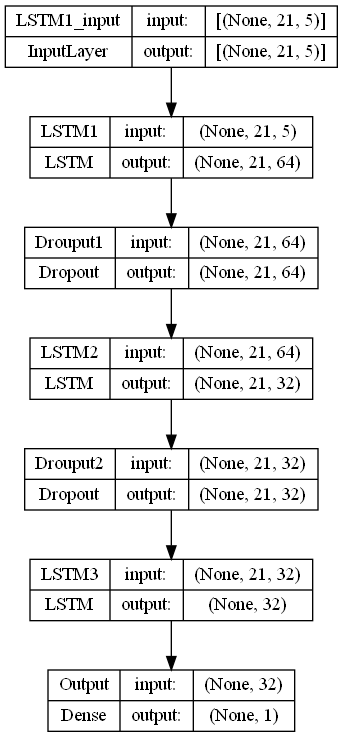

In [62]:
# plot layers
plot_model(model, to_file='./img/model.png', show_shapes=True, show_layer_names=True) #the "./" means that the folder
# img is inside the same folder of the code's file

In [63]:
# Specify callback functions

#We will save the best result of the model in our directory.
model_path = (results_path / 'model.h5').as_posix() #The path where the best results will be saved 

logdir = os.path.join("./tensorboard/logs", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Callback function: what will be passed: 
# Explanation below
my_callbacks = [
    EarlyStopping(patience=20, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=model_path, verbose=1, monitor='loss', save_best_only=True),
    TensorBoard(log_dir=logdir, histogram_freq=1) 
]
"""
My_callback (earlyStopping): the performance of the model will be monitored by its LOSS function (the goal is to minimize
it . Also, based on that, it will save only the best model. The patience param. means that: the model will be evaluating the 
loss function values. If, in 20 rounds (the patience value), it doesn't enhance the loss value, it will stop.
"""

"\nMy_callback (earlyStopping): the performance of the model will be monitored by its LOSS function (the goal is to minimize\nit . Also, based on that, it will save only the best model. The patience param. means that: the model will be evaluating the \nloss function values. If, in 20 rounds (the patience value), it doesn't enhance the loss value, it will stop.\n"

### Training the model (model fit)

In [64]:
# Model fitting
model.fit(g,
          epochs=500, 
          verbose=1, 
          callbacks=my_callbacks, 
          shuffle=False,
          class_weight=class_weight)



Epoch 1/500
35/35 [==============================] - ETA: 0s - loss: 0.6951 - accuracy: 0.5775 - precision: 0.2909 - recall: 0.2644
Epoch 1: loss improved from inf to 0.69511, saving model to results/lstm_time_series\model.h5
35/35 [==============================] - 19s 138ms/step - loss: 0.6951 - accuracy: 0.5775 - precision: 0.2909 - recall: 0.2644
Epoch 2/500
35/35 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5409 - precision: 0.3197 - recall: 0.4429
Epoch 2: loss improved from 0.69511 to 0.69325, saving model to results/lstm_time_series\model.h5
35/35 [==============================] - 5s 155ms/step - loss: 0.6933 - accuracy: 0.5409 - precision: 0.3197 - recall: 0.4429
Epoch 3/500
35/35 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5594 - precision: 0.3339 - recall: 0.4414
Epoch 3: loss improved from 0.69325 to 0.69248, saving model to results/lstm_time_series\model.h5
35/35 [==============================] - 5s 156ms/step - loss

In [65]:
#Evaluate model performance
#%tensorboard --logdir ./tensorboard/logs

### Prediction of the Test dataset

In [66]:
# predictions 
#ypred = model.predict(g_, verbose=False) #This option is when you want to retrieve the raw numbers of prediciton, eg:
#the absolute probability of 1s and 0s. In the commmand below we define that everythin above a treshold, we classify as 1.

ypred = np.where(model.predict(g_, verbose=False) > 0.5, 1, 0)
print(f'Comparing ypred = 1 to total sample:\nCount 1:{ypred.sum()}\nTotal obs:{ypred.shape[0]} \
     \nRatio:{ypred.sum()/ypred.shape[0]}')

Comparing ypred = 1 to total sample:
Count 1:482
Total obs:1078      
Ratio:0.44712430426716143


<AxesSubplot:title={'center':'Time series of y_pred'}>

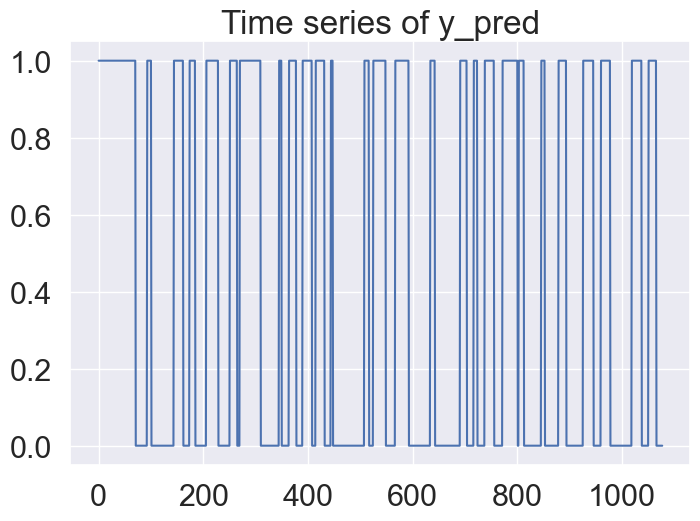

In [67]:
dfplot = pd.DataFrame(ypred,columns=["y_pred"])
dfplot['y_pred'].plot(kind='line', title=f'Time series of y_pred')
#ypred

### Evaluation metrics - accuracy and precision

In [68]:
# load model - os.path.abspath(model_path)
model = load_model(model_path) #Load the previous model from our directory. Therefore you don't need to run 
#the model everytime you open this program. For example, if you are using your strategy, you can update your model every end
#of the week, and within the week you keep using the result's parameters from previous week.


# summarize model
model.summary()

# If you want to evaluate the model in the TRAINING data (just change the "g"):
score = model.evaluate(g, verbose=0)
print(f'Training set:{model.metrics_names[1]}, {score[1]*100:.4}%, {model.metrics_names[2]}, {score[2]*100:.4}%') #If you want a different metric, e.g. Precision, you can change the
#number, eg: model.metrics_names[2]}, {score[2]*100

# evaluate the model in the TEST data
score = model.evaluate(g_, verbose=0)
print(f'Validation set:{model.metrics_names[1]}, {score[1]*100:.4}%, {model.metrics_names[2]}, {score[2]*100:.4}%') #If you want a different metric, e.g. Precision, you can change the 
#number, eg: model.metrics_names[2]}, {score[2]*100

# If you want to evaluate the model in the TRAINING data (just change the "g"):
score = model.evaluate(g_backtest, verbose=0)
print(f'Test/backtest set:{model.metrics_names[1]}, {score[1]*100:.4}%, {model.metrics_names[2]}, {score[2]*100:.4}%') #If you want a different metric, e.g. Precision, you can change the 
#number, eg: model.metrics_names[2]}, {score[2]*100

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 21, 64)            17920     
                                                                 
 Drouput1 (Dropout)          (None, 21, 64)            0         
                                                                 
 LSTM2 (LSTM)                (None, 21, 32)            12416     
                                                                 
 Drouput2 (Dropout)          (None, 21, 32)            0         
                                                                 
 LSTM3 (LSTM)                (None, 32)                8320      
                                                                 
 Output (Dense)              (None, 1)                 33        
                                                                 
Total params: 38,689
Trainable params: 38,689
Non-traina

### Retrieving the stored results H5 file

In [69]:
#Retrieving the stored results
import tables
from pandas import HDFStore
hdf = HDFStore('results/lstm_time_series/model.h5')
print(list(hdf.keys()))

[]


### Performance of strategy - Predicting y variable for the most recent data (dataset neither used for training nor to testing).

In [70]:
#Calculating the strategy performance: we will use two main columns of the dataset: the one with future returns, and the other with the position that the threshold
#was reached (also, if its not reached, the position is the lenght of "period"

#------------------------------------------------------------------------------------------------------------------------------
#First, we merge two datasets, one with the features and other with Closing price
#Dataset w/ features and dates exactly the same as our BACKTEST dataset
dfRet = pd.read_csv(f'datasets/{asset}_XandY_dataset_allFeatures.csv', index_col=0, parse_dates=True, delimiter=',')[-(len(Xbacktest)-seqlen):]

#Insert the PREDICTION Ylabel in the dataset. Ylabel retrieved by the model

yPredBacktest = np.where(model.predict(g_backtest, verbose=False) > 0.5, 1, 0)
print(f'y_pred shape: {yPredBacktest.shape}')
print(f'\nY_variable value counts = 1: {np.count_nonzero(yPredBacktest)} ocurrences\n')


#Retrieving the dataset with the future returns observed
df_backtest = dfRet.copy(deep=True)
print(f'\n\nPeriod of Testing data\nFrom date {df_backtest.index[0]}\nto date {df_backtest.index[-1]}\n')
df_backtest['yPredBacktest'] = yPredBacktest #Inserting the predicted label as a new dataframe columns
df_backtest.to_csv(f'datasets/dfBacktestPrediction.csv')

#Calling the built function that calculates the cumulative return
results = perf_backtest(df_backtest, colRet='Fut_return_period', colPos='PosStop', colPred='yPredBacktest')
print(f'Return full period\n{results[1][-1:]}')

y_pred shape: (483, 1)

Y_variable value counts = 1: 200 ocurrences



Period of Testing data
From date 2021-01-12 00:00:00
to date 2022-12-09 00:00:00

How many predictions = 1: 45

Return full period
    return  cumulative_return_in_Period
44 -0.0382                      -0.0618


In [71]:
float(results[1].iloc[-1:,-1])

-0.061812398891800346

In [72]:
timedelta = df_backtest.index[-1] - df_backtest.index[0]
qtyYears = timedelta.days/365
retA = (1+ float(results[1].iloc[-1:,-1]))**(1/qtyYears)-1

print(f'\nReturn a.a. = {retA}')


Return a.a. = -0.03290750671316511


#### BENCHMARK RETURN TO COMPARE

In [73]:
#Benchmark: the return of a buy and hold strat
print(f'\nBENCHMARK: Buy and hold the asset\n')
df_bench = df_backtest.copy(deep=True)
df_colsRet = df_bench[['Fut_return_period','PosStop']]
df_bench['Fut_return_period'] = df_colsRet[['Fut_return_period']] #When they both have the dates as index, we can merge them easily with this step
df_bench['PosStop'] = df_colsRet[['PosStop']] #When they both have the dates as index, we can merge them easily with this step
df_bench['All_1'] = 1

display(df_bench.shape)
results = perf_backtest(df_bench, colRet='Fut_return_period', colPos='PosStop', colPred='All_1')
res = results[1][-1:]

print(f'First method of calculating Benchmark result\nBenchmark return from test period:\n\n{res}\n')

#Benchmark 2  - Just to confirm: the return of a buy and hold strat - The same calculation of above bot from different way. 
#The results from here and above should be similar
"""
dftest = pd.read_csv(f'datasets/{asset}_historical_max.csv', index_col=0, parse_dates=True, delimiter=',')
dftest_beg = dftest[dftest.index == df_bench.index[0]] #Initial date
print(f'init date {dftest_beg}')
dftest_end = dftest[dftest.index == df_bench.index[-1]] #End date
print(f'init date {dftest_end}')
retPer = dftest_end['Close'].values[0] / dftest_beg['Close'].values[0] -1

print(f'Checking the BENCHMARK return for the period of test: {retPer}')
"""

timedelta = df_backtest.index[-1] - df_backtest.index[0]
qtyYears = timedelta.days/365
retA = (1+ float(results[1].iloc[-1:,-1]))**(1/qtyYears)-1

print(f'\nReturn a.a. = {retA}')


BENCHMARK: Buy and hold the asset



(483, 12)

How many predictions = 1: 97

First method of calculating Benchmark result
Benchmark return from test period:

    return  cumulative_return_in_Period
96  0.0060                       0.1576


Return a.a. = 0.0797789453632376


# ==========================================================================================

### Hiperparameter Optimization

In [74]:
#Hiperparameter optimization
def build_model(hp):
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('units1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('units2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('units3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation', values = ['relu', 'elu'], ordered = False)
    
    model.add(LSTM(hp_units1, input_shape=(seqlen, numfeat), activation=hp_activation1, return_sequences=True, name='LSTM1'))   
    model.add(Dropout(hp_dropout1, name='Drouput1'))
    
    model.add(LSTM(hp_units2, activation = hp_activation2, return_sequences=True, name='LSTM2'))
    model.add(Dropout(hp_dropout2, name='Drouput2'))

    model.add(LSTM(hp_units3, activation = hp_activation3, return_sequences=False, name='LSTM3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy', 
                           Precision(),
                           Recall()])

    return model

In [75]:
# initialize an early stopping callback to prevent the model from
# We are keeping 3 different call backs because we want to store separately for each type of optimization: random search, bayesian, etc
# overfitting/spending too much time training with minimal gains
callback1 = [EarlyStopping(patience=5, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
             TensorBoard(log_dir="./tensorboard/rslogs")]

callback2 = [EarlyStopping(patience=5, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
             TensorBoard(log_dir="./tensorboard/hblogs")]

callback3 = [EarlyStopping(patience=5, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
             TensorBoard(log_dir="./tensorboard/bologs")]

### Approach 1 - Bayesian Optimiz

#### Defining the optimization method

In [76]:
# BayesianOptimization algorithm from keras tuner
botuner = BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=15,
    num_initial_points=2,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    overwrite=True,
    directory="./keras",
    project_name="botrial")

#### Launch tuning process

In [77]:
# launch tuning process
botuner.search(g, epochs=50, validation_data=g_, callbacks=callback3, class_weight = class_weight, shuffle=False)

Trial 15 Complete [00h 00m 52s]
val_accuracy: 0.5074211359024048

Best val_accuracy So Far: 0.7087198495864868
Total elapsed time: 00h 26m 58s
INFO:tensorflow:Oracle triggered exit


In [78]:
best_bohp = botuner.get_best_hyperparameters()[0]
print(best_bohp.values)

{'units1': 4, 'units2': 8, 'units3': 4, 'Dropout_rate': 0.0, 'learning_rate': 0.01, 'activation': 'elu'}


#### Tensorboard - visualize the hyperparamet tuning process

In [79]:
#Visualize the hyperparameter tuning process
%tensorboard --logdir ./tensorboard/bologs

Reusing TensorBoard on port 6006 (pid 15476), started 1:40:13 ago. (Use '!kill 15476' to kill it.)

#### Model Fit - run through EPOCHS while tuning

In [80]:
# Specify callback functions for the second model

#We will save the best result of the model in our directory.
model_path = (results_path / 'model02.h5').as_posix() #The path where the best results will be saved 

logdir = os.path.join("./tensorboard/logs", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Callback function: what will be passed: 
# Explanation below
my_callbacks = [
    EarlyStopping(patience=20, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=model_path, verbose=1, monitor='loss', save_best_only=True),
    TensorBoard(log_dir=logdir, histogram_freq=1) 
]
"""
My_callback (earlyStopping): the performance of the model will be monitored by its LOSS function (the goal is to minimize
it . Also, based on that, it will save only the best model. The patience param. means that: the model will be evaluating the 
loss function values. If, in 20 rounds (the patience value), it doesn't enhance the loss value, it will stop.
"""

"\nMy_callback (earlyStopping): the performance of the model will be monitored by its LOSS function (the goal is to minimize\nit . Also, based on that, it will save only the best model. The patience param. means that: the model will be evaluating the \nloss function values. If, in 20 rounds (the patience value), it doesn't enhance the loss value, it will stop.\n"

In [81]:
# display the best hyperparameter values for the model based on the defined objective function
best_bohp = botuner.get_best_hyperparameters()

model3 = build_model(best_bohp[0])

# Model fitting
model3.fit(g,
          epochs=500, 
          verbose=1, 
          callbacks=my_callbacks, 
          shuffle=False,
          class_weight=class_weight)

# summarize model3
model3.summary()

Epoch 1/500
34/35 [============================>.] - ETA: 0s - loss: 0.6968 - accuracy: 0.5110 - precision: 0.2899 - recall: 0.4097
Epoch 1: loss improved from inf to 0.69634, saving model to results/lstm_time_series\model02.h5
35/35 [==============================] - 5s 26ms/step - loss: 0.6963 - accuracy: 0.5126 - precision: 0.2899 - recall: 0.4085
Epoch 2/500
34/35 [============================>.] - ETA: 0s - loss: 0.6944 - accuracy: 0.5381 - precision: 0.2889 - recall: 0.3461
Epoch 2: loss improved from 0.69634 to 0.69395, saving model to results/lstm_time_series\model02.h5
35/35 [==============================] - 1s 24ms/step - loss: 0.6940 - accuracy: 0.5396 - precision: 0.2889 - recall: 0.3450
Epoch 3/500
34/35 [============================>.] - ETA: 0s - loss: 0.6944 - accuracy: 0.5312 - precision: 0.2991 - recall: 0.3933
Epoch 3: loss improved from 0.69395 to 0.69390, saving model to results/lstm_time_series\model02.h5
35/35 [==============================] - 1s 24ms/step - lo

#### Evaluation metrics - accuracy and precision

In [82]:
print(f"Evaluation metrics for different sets")
# If you want to evaluate the model3 in the TRAINING data (just change the "g"):
score = model3.evaluate(g, verbose=0)
print(f'Training set: {model3.metrics_names[1]}, {score[1]*100:.4}%, {model3.metrics_names[2]}, {score[2]*100:.4}%') #If you want a different metric, e.g. Precision, you can change the 
#number, eg: model3.metrics_names[2]}, {score[2]*100

# evaluate the model3 in the TEST data
score = model3.evaluate(g_, verbose=0)
print(f'Validation set: {model3.metrics_names[1]}, {score[1]*100:.4}%, {model3.metrics_names[2]}, {score[2]*100:.4}%') #If you want a different metric, e.g. Precision, you can change the 
#number, eg: model3.metrics_names[2]}, {score[2]*100

# If you want to evaluate the model3 in the TRAINING data (just change the "g"):
score = model3.evaluate(g_backtest, verbose=0)
print(f'Test/backtest set: {model3.metrics_names[1]}, {score[1]*100:.4}%, {model3.metrics_names[2]}, {score[2]*100:.4}%') #If you want a different metric, e.g. Precision, you can change the 
#number, eg: model3.metrics_names[2]}, {score[2]*100


Evaluation metrics for different sets
Training set: accuracy, 64.24%, precision, 42.91%
Validation set: accuracy, 54.08%, precision, 31.21%
Test/backtest set: accuracy, 47.83%, precision, 37.2%


In [83]:
# display tuning results summary
botuner.results_summary()

Results summary
Results in ./keras\botrial
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 4
units2: 8
units3: 4
Dropout_rate: 0.0
learning_rate: 0.01
activation: elu
Score: 0.7087198495864868
Trial summary
Hyperparameters:
units1: 32
units2: 4
units3: 4
Dropout_rate: 0.1
learning_rate: 0.01
activation: elu
Score: 0.7077922224998474
Trial summary
Hyperparameters:
units1: 16
units2: 28
units3: 4
Dropout_rate: 0.0
learning_rate: 0.0001
activation: elu
Score: 0.7077922224998474
Trial summary
Hyperparameters:
units1: 32
units2: 4
units3: 16
Dropout_rate: 0.5
learning_rate: 0.0001
activation: elu
Score: 0.7022263407707214
Trial summary
Hyperparameters:
units1: 32
units2: 28
units3: 4
Dropout_rate: 0.5
learning_rate: 0.0001
activation: elu
Score: 0.701298713684082
Trial summary
Hyperparameters:
units1: 12
units2: 32
units3: 12
Dropout_rate: 0.30000000000000004
learning_rate: 0.01
activation: elu
Score: 0.7003710865974426
Trial summary
Hyperparameters:
units1: 8
units2: 12
units

#### Predicting y variable for the most recent data (dataset neither used for training nor to testing).

In [84]:
#Calculating the strategy performance: we will use two main columns of the dataset: the one with future returns, and the other with the position that the threshold
#was reached (also, if its not reached, the position is the lenght of "period"

#------------------------------------------------------------------------------------------------------------------------------
#First, we merge two datasets, one with the features and other with Closing price
#Dataset w/ features and dates exactly the same as our BACKTEST dataset
dfRet = pd.read_csv(f'datasets/{asset}_XandY_dataset_allFeatures.csv', index_col=0, parse_dates=True, delimiter=',')[-(len(Xbacktest)-seqlen):]

#Insert the PREDICTION Ylabel in the dataset. Ylabel retrieved by the model

yPredBacktest = np.where(model3.predict(g_backtest, verbose=False) > 0.5, 1, 0)
print(f'y_pred shape: {yPredBacktest.shape}')
print(f'\nY_variable value counts = 1: {np.count_nonzero(yPredBacktest)} ocurrences\n')


#Retrieving the dataset with the future returns observed
df_backtest = dfRet.copy(deep=True)
print(f'\n\nPeriod of Testing data\nFrom date {df_backtest.index[0]}\nto date {df_backtest.index[-1]}\n')
df_backtest['yPredBacktest'] = yPredBacktest #Inserting the predicted label as a new dataframe columns
df_backtest.to_csv(f'datasets/dfBacktestPrediction.csv')

#Calling the built function that calculates the cumulative return
results = perf_backtest(df_backtest, colRet='Fut_return_period', colPos='PosStop', colPred='yPredBacktest')
print(f'Return full period\n{results[1][-1:]}')

y_pred shape: (483, 1)

Y_variable value counts = 1: 336 ocurrences



Period of Testing data
From date 2021-01-12 00:00:00
to date 2022-12-09 00:00:00

How many predictions = 1: 84

Return full period
    return  cumulative_return_in_Period
83 -0.0136                       0.1560
